<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Sun Oct  6 15:53:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P0             N/A / ERR!  |       0MiB /   4096MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.4.0+cu124


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. More Hidden layers
2. More Longger Training
3. Use Transfer Learning

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path("data/")
image_path = data_path / 'pizza_steak_sushi'

# if the image folder doesn't exist, download and prepare it...
if image_path.is_dir():
    print(f'{image_path} directory sudah ada, skipping download')
else:
    print(f'{image_path} tidak ada, mulai download')
    image_path.mkdir(parents=True, exist_ok=True)
    
# download the dataset from mrdbourke github
with open(data_path / 'pizza_steak_sushi.zip', mode="wb") as f:
    requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print('Downloading dataset')
    f.write(requests.content)
    
# unzip dataset
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping dataset')
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory sudah ada, skipping download
Unzipping dataset


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [6]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path/ 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Random Image Path : data\pizza_steak_sushi\train\sushi\2797464.jpg
Image Class : sushi
Image Height : 512 and Width : 512


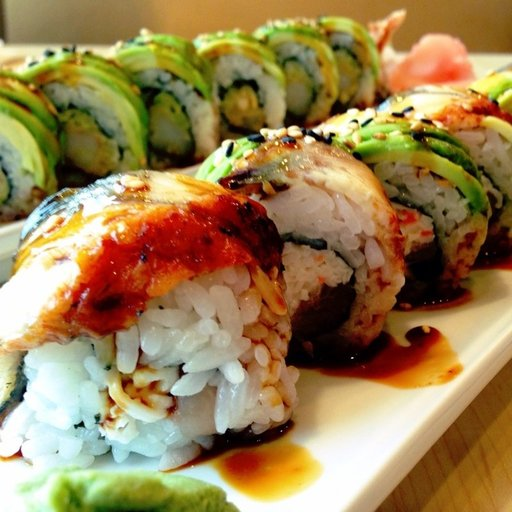

In [7]:
# Visualize an image
# importings
import random
from PIL import Image

# get image path list
image_path_list = list(image_path.glob("*/*/*.jpg"))

# pick a random image
random_image_path = random.choice(image_path_list)

# get class image from pathname
image_class = random_image_path.parent.stem

# open images
img = Image.open(random_image_path)

# print the metadata
print(f'Random Image Path : {random_image_path}')
print(f'Image Class : {image_class}')
print(f'Image Height : {img.height} and Width : {img.width}')
img

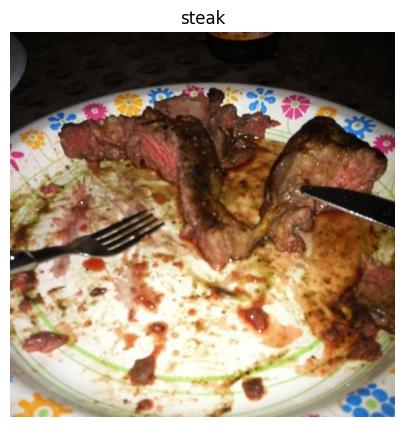

In [8]:
# Do the image visualization with matplotlib
import matplotlib.pyplot as plt
import numpy as np

# get image path list
image_path_list = list(image_path.glob("*/*/*.jpg"))

# pick a random image
random_image_path = random.choice(image_path_list)

# get class image from pathname
image_class = random_image_path.parent.stem

# open images
img = Image.open(random_image_path)

# turn the image into array
img_array = np.asarray(img)

# buat kerangka nya
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title(image_class)
plt.axis(False)
plt.show()

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [9]:
# 3.1 Transforming data with torchvision.transforms
import torchvision.transforms.v2 as trans
from torchvision import datasets
from torch.utils.data import DataLoader

In [84]:
# Write transform for turning images into tensors
transforming_image_train = trans.Compose([
    trans.Resize(size=(64,64)),
    # trans.AutoAugment(trans.AutoAugmentPolicy.IMAGENET),
    # trans.RandAugment(),
    trans.RandomHorizontalFlip(p=0.5),
    trans.ToImage(),
    trans.ToDtype(torch.float32, scale=True)
])

transforming_image_test = trans.Compose([
    trans.Resize(size=(64,64)),
    trans.ToImage(),
    trans.ToDtype(torch.float32, scale=True)
])

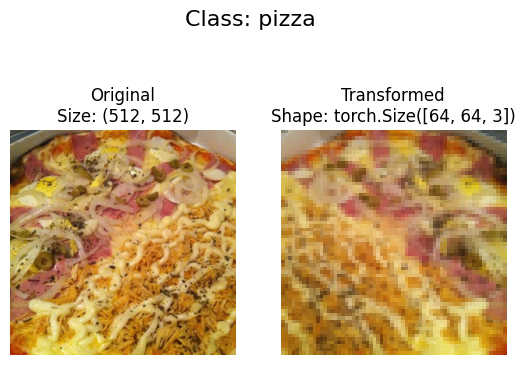

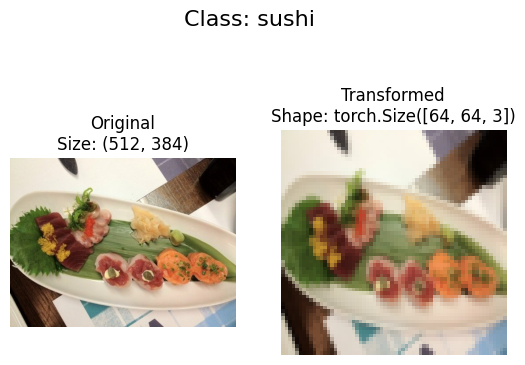

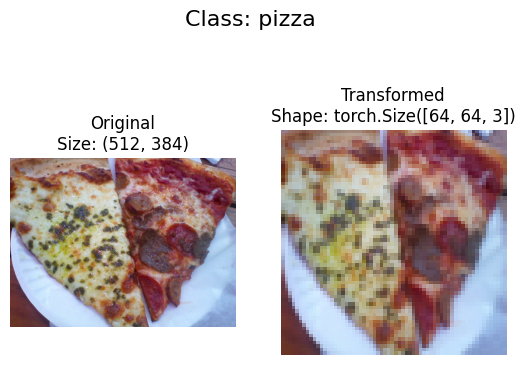

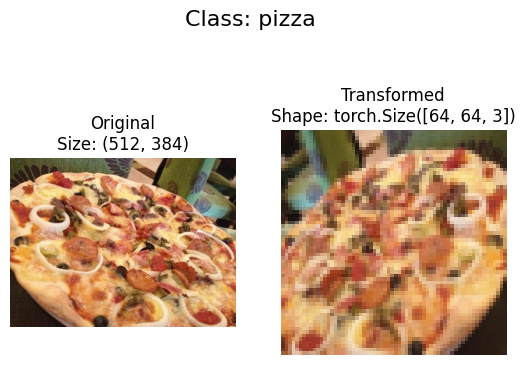

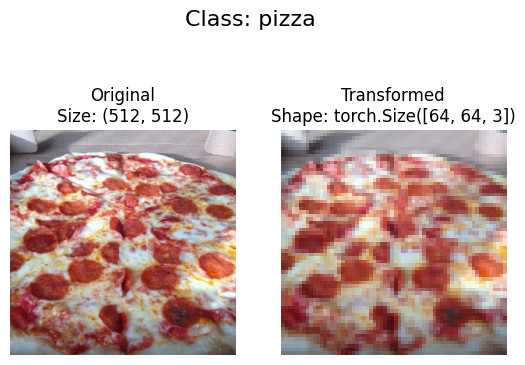

In [85]:
# Write a function to plot transformed images
from helper_functions import plot_transformed_images

plot_transformed_images(image_paths=image_path_list,transform=transforming_image_train,n=5)

### Load image data using `ImageFolder`

In [86]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=transforming_image_train,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=transforming_image_test)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomHorizontalFlip(p=0.5)
                  ToImage()
                  ToDtype(scale=True)
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  ToImage()
                  ToDtype(scale=True)
            ))

In [87]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [88]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [89]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [90]:
# Turn train and test Datasets into DataLoaders
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2e71ee4a7d0>,
 <torch.utils.data.dataloader.DataLoader at 0x2e71ee69030>)

In [91]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(8, 3)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [92]:
from torch import relu


class TinyVGGModel(nn.Module):
    def __init__(self,
                 input_shape : int,
                 hidden_layer: int,
                 output_layer: int):
        super().__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_layer, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layer, out_channels=hidden_layer*2, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layer*2, out_channels=hidden_layer*2, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layer*2,out_channels=hidden_layer*4, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layer*4, out_channels=hidden_layer*4, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layer*4, out_channels=hidden_layer*4, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # self.conv_layer4 = nn.Sequential(
        #     nn.Conv2d(in_channels=hidden_layer*4, out_channels=hidden_layer*4, kernel_size=3),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=hidden_layer*4, out_channels=hidden_layer*4, kernel_size=3),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2)
        # )
        
        # self.conv_layer5 = nn.Sequential(
        #     nn.Conv2d(in_channels=hidden_layer*4, out_channels=hidden_layer*4, kernel_size=3),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=hidden_layer*4, out_channels=hidden_layer*4, kernel_size=3),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2)
        # )
        
        # tip kalo misalnya hidden layer terakhir * 4 harus ikut juga *4 untuk hidden layer dan baru shape nya kaya dibawah
        self.classifier_layer = nn.Sequential(
            nn.Flatten(),
            # di *4 dulu karena hidden layer terakhir di conv_layer5 itu *4
            nn.Linear(in_features=hidden_layer*4*4*4, out_features=output_layer)
        )

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        # x = self.conv_layer4(x)
        # x = self.conv_layer5(x)
        # print(x.shape)
        x = self.classifier_layer(x)
        return x

In [93]:
model_test = TinyVGGModel(
    input_shape=3,
    hidden_layer=8,
    output_layer=len(class_names)
).to(device)

model_test

TinyVGGModel(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [94]:
# Create dummy input

dummy = torch.randn(size=(1, 3, 64, 64)).to(device)

model_test.eval()
with torch.inference_mode():
    print(model_test(dummy))

tensor([[ 0.0164, -0.0433, -0.0140]], device='cuda:0')


In [95]:
from torchinfo import summary

summary(model_test, input_size=(32 ,3 ,64 ,64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGModel                             [32, 3]                   --
├─Sequential: 1-1                        [32, 16, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 8, 62, 62]           224
│    └─ReLU: 2-2                         [32, 8, 62, 62]           --
│    └─Conv2d: 2-3                       [32, 16, 60, 60]          1,168
│    └─ReLU: 2-4                         [32, 16, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 16, 30, 30]          --
├─Sequential: 1-2                        [32, 32, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 16, 28, 28]          2,320
│    └─ReLU: 2-7                         [32, 16, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 32, 26, 26]          4,640
│    └─ReLU: 2-9                         [32, 32, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 32, 13, 13]          --
├─Seq

## 4. Create training and testing functions for `model_0`.

In [78]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device) 

    # 1. Forward pass
    y_pred = model(X)
    # print(y_pred)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc 

In [79]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)
      # print(test_pred_logits)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    
  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [80]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [96]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGGModel(input_shape=3,
                       hidden_layer=8,
                       output_layer=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), 
                             lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1008 | train_acc: 0.2500 | test_loss: 1.0969 | test_acc: 0.5729
Epoch: 2 | train_loss: 1.1000 | train_acc: 0.2852 | test_loss: 1.0900 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.1004 | train_acc: 0.2422 | test_loss: 1.0929 | test_acc: 0.3617
Epoch: 4 | train_loss: 1.0950 | train_acc: 0.3750 | test_loss: 1.0972 | test_acc: 0.3125
Epoch: 5 | train_loss: 1.0851 | train_acc: 0.4297 | test_loss: 1.0977 | test_acc: 0.3021


In [97]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = TinyVGGModel(input_shape=3,
                       hidden_layer=8,
                       output_layer=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), 
                             lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1008 | train_acc: 0.2500 | test_loss: 1.0969 | test_acc: 0.5729
Epoch: 2 | train_loss: 1.0999 | train_acc: 0.2852 | test_loss: 1.0901 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0989 | train_acc: 0.2461 | test_loss: 1.0938 | test_acc: 0.4025
Epoch: 4 | train_loss: 1.0943 | train_acc: 0.4258 | test_loss: 1.0969 | test_acc: 0.2917
Epoch: 5 | train_loss: 1.0800 | train_acc: 0.4297 | test_loss: 1.0961 | test_acc: 0.3125
Epoch: 6 | train_loss: 1.0763 | train_acc: 0.4531 | test_loss: 1.0608 | test_acc: 0.3220
Epoch: 7 | train_loss: 1.0288 | train_acc: 0.5352 | test_loss: 1.0505 | test_acc: 0.2917
Epoch: 8 | train_loss: 1.0037 | train_acc: 0.5703 | test_loss: 1.0853 | test_acc: 0.3125
Epoch: 9 | train_loss: 0.9532 | train_acc: 0.4766 | test_loss: 0.9972 | test_acc: 0.3627
Epoch: 10 | train_loss: 0.9408 | train_acc: 0.4258 | test_loss: 1.0074 | test_acc: 0.5739
Epoch: 11 | train_loss: 1.0991 | train_acc: 0.4922 | test_loss: 0.9808 | test_acc: 0.4233
Epoch: 12 | train_l

In [98]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_2 = TinyVGGModel(input_shape=3,
                       hidden_layer=8,
                       output_layer=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), 
                             lr=0.001)

model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1008 | train_acc: 0.2500 | test_loss: 1.0969 | test_acc: 0.5729
Epoch: 2 | train_loss: 1.0999 | train_acc: 0.2891 | test_loss: 1.0901 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0987 | train_acc: 0.2461 | test_loss: 1.0941 | test_acc: 0.4129
Epoch: 4 | train_loss: 1.0948 | train_acc: 0.4141 | test_loss: 1.0969 | test_acc: 0.2812
Epoch: 5 | train_loss: 1.0813 | train_acc: 0.4258 | test_loss: 1.0978 | test_acc: 0.3125
Epoch: 6 | train_loss: 1.0771 | train_acc: 0.4453 | test_loss: 1.0657 | test_acc: 0.3220
Epoch: 7 | train_loss: 1.0338 | train_acc: 0.5312 | test_loss: 1.0544 | test_acc: 0.2917
Epoch: 8 | train_loss: 1.0141 | train_acc: 0.4375 | test_loss: 1.0821 | test_acc: 0.3021
Epoch: 9 | train_loss: 0.9581 | train_acc: 0.4805 | test_loss: 0.9975 | test_acc: 0.3731
Epoch: 10 | train_loss: 0.9448 | train_acc: 0.4180 | test_loss: 1.0229 | test_acc: 0.4830
Epoch: 11 | train_loss: 1.1000 | train_acc: 0.4375 | test_loss: 0.9734 | test_acc: 0.3920
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [99]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_3 = TinyVGGModel(3,
                       16,
                       len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), 
                             lr=0.001)

model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1061 | train_acc: 0.2695 | test_loss: 1.0912 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.1004 | train_acc: 0.2891 | test_loss: 1.1033 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0986 | train_acc: 0.3477 | test_loss: 1.1099 | test_acc: 0.2500
Epoch: 4 | train_loss: 1.1062 | train_acc: 0.3047 | test_loss: 1.0978 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0711 | train_acc: 0.4922 | test_loss: 1.0411 | test_acc: 0.5009
Epoch: 6 | train_loss: 1.0704 | train_acc: 0.3164 | test_loss: 1.0627 | test_acc: 0.3703
Epoch: 7 | train_loss: 1.0228 | train_acc: 0.4258 | test_loss: 1.0485 | test_acc: 0.2812
Epoch: 8 | train_loss: 0.9160 | train_acc: 0.5820 | test_loss: 0.9780 | test_acc: 0.5227
Epoch: 9 | train_loss: 1.0405 | train_acc: 0.4219 | test_loss: 0.9306 | test_acc: 0.6146
Epoch: 10 | train_loss: 1.0053 | train_acc: 0.3906 | test_loss: 1.0238 | test_acc: 0.5047
Epoch: 11 | train_loss: 1.0145 | train_acc: 0.6172 | test_loss: 1.0598 | test_acc: 0.4631
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [100]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

data\pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [101]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\test'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\pizza'.
There are 0 directories and 58 images in 'data\pizza_steak_sushi_20_percent\test\steak'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\train'.
There are 0 directories and 154 images in 'data\pizza_steak_sushi_20_percent\train\pizza'.
There are 0 directories and 146 images in 'data\pizza_steak_sushi_20_percent\train\steak'.
There are 0 directories and 150 images in 'data\pizza_steak_sushi_20_percent\train\sushi'.


Excellent, we now have double the training and testing images... 

In [102]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [103]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader

simple_transform_train = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToImage(),
  transforms.ToDtype(torch.float32, scale=True),
])

simple_transform_test = transforms.Compose([
  transforms.Resize(size=(64,64)),
  transforms.ToImage(),
  transforms.ToDtype(torch.float32, scale=True),
])

# Create datasets
twenty_datasets_train = datasets.ImageFolder(root=train_data_20_percent_path,
                                             transform=simple_transform_train)
twenty_datasets_test = datasets.ImageFolder(root=test_data_20_percent_path,
                                            transform=transforming_image_test)

# Create dataloaders
twenty_dataloader_train = DataLoader(dataset=twenty_datasets_train,
                                     batch_size=32,
                                     shuffle=True)
twenty_dataloader_test = DataLoader(dataset=twenty_datasets_train,
                                    batch_size=32,
                                    shuffle=False)

In [108]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_4 = TinyVGGModel(input_shape=3,
                       hidden_layer=16,
                       output_layer=len(class_names)).to(device)

optimizer = torch.optim.Adam(model_4.parameters(),
                             lr=0.0015)
loss_fn = nn.CrossEntropyLoss()


model_4_results = train(model=model_4,
                        train_dataloader=twenty_dataloader_train,
                        test_dataloader=twenty_dataloader_test,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1017 | train_acc: 0.2979 | test_loss: 1.0964 | test_acc: 0.3750
Epoch: 2 | train_loss: 1.0749 | train_acc: 0.4604 | test_loss: 1.0796 | test_acc: 0.3812
Epoch: 3 | train_loss: 1.0362 | train_acc: 0.4875 | test_loss: 0.9603 | test_acc: 0.5083
Epoch: 4 | train_loss: 0.9778 | train_acc: 0.5229 | test_loss: 0.9795 | test_acc: 0.5667
Epoch: 5 | train_loss: 0.9558 | train_acc: 0.5896 | test_loss: 0.9004 | test_acc: 0.5958
Epoch: 6 | train_loss: 0.9515 | train_acc: 0.5146 | test_loss: 0.8990 | test_acc: 0.5917
Epoch: 7 | train_loss: 0.9064 | train_acc: 0.5854 | test_loss: 0.8704 | test_acc: 0.6396
Epoch: 8 | train_loss: 0.9021 | train_acc: 0.6188 | test_loss: 0.8615 | test_acc: 0.6354
Epoch: 9 | train_loss: 0.8569 | train_acc: 0.6208 | test_loss: 0.8264 | test_acc: 0.6604
Epoch: 10 | train_loss: 0.8508 | train_acc: 0.6188 | test_loss: 0.8633 | test_acc: 0.5958
Epoch: 11 | train_loss: 0.8498 | train_acc: 0.6375 | test_loss: 0.8223 | test_acc: 0.6292
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [151]:
# download custom image
import requests

# setup custom image path
custom_image_path = data_path / "04-steak-1.jpeg"

# download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        # when downloading from github need to use raw file link
        requests = requests.get('https://awsimages.detik.net.id/community/media/visual/2023/06/18/tingkat-kematangan-steak_169.jpeg?w=1200')
        print(f'Downloading {custom_image_path}...')
        f.write(requests.content)
else:
    print(f'{custom_image_path} already exists, skipping download.')

In [152]:
import torchvision

In [153]:
# read custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f'Custom image {custom_image_uint8}')
print(f'custom image shape {custom_image_uint8.shape}')
print(f'custom image data type {custom_image_uint8.dtype}')

Custom image tensor([[[ 33,  33,  35,  ..., 157, 156, 156],
         [ 33,  33,  35,  ..., 158, 157, 157],
         [ 35,  35,  35,  ..., 160, 159, 159],
         ...,
         [202, 202, 202,  ..., 176, 174, 172],
         [202, 202, 202,  ..., 177, 175, 173],
         [202, 202, 202,  ..., 178, 176, 174]],

        [[  2,   2,   1,  ..., 126, 125, 125],
         [  2,   2,   1,  ..., 127, 126, 126],
         [  1,   1,   1,  ..., 129, 128, 128],
         ...,
         [202, 202, 202,  ..., 131, 129, 127],
         [202, 202, 202,  ..., 132, 130, 128],
         [202, 202, 202,  ..., 133, 131, 129]],

        [[  0,   0,   0,  ...,  82,  81,  81],
         [  0,   0,   0,  ...,  83,  82,  82],
         [  0,   0,   0,  ...,  85,  84,  84],
         ...,
         [204, 204, 204,  ...,  74,  72,  70],
         [204, 204, 204,  ...,  75,  73,  71],
         [204, 204, 204,  ...,  76,  74,  72]]], dtype=torch.uint8)
custom image shape torch.Size([3, 676, 1200])
custom image data type torch

In [154]:
# load the image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
custom_image.dtype, custom_image.shape, custom_image

(torch.float32,
 torch.Size([3, 676, 1200]),
 tensor([[[0.1294, 0.1294, 0.1373,  ..., 0.6157, 0.6118, 0.6118],
          [0.1294, 0.1294, 0.1373,  ..., 0.6196, 0.6157, 0.6157],
          [0.1373, 0.1373, 0.1373,  ..., 0.6275, 0.6235, 0.6235],
          ...,
          [0.7922, 0.7922, 0.7922,  ..., 0.6902, 0.6824, 0.6745],
          [0.7922, 0.7922, 0.7922,  ..., 0.6941, 0.6863, 0.6784],
          [0.7922, 0.7922, 0.7922,  ..., 0.6980, 0.6902, 0.6824]],
 
         [[0.0078, 0.0078, 0.0039,  ..., 0.4941, 0.4902, 0.4902],
          [0.0078, 0.0078, 0.0039,  ..., 0.4980, 0.4941, 0.4941],
          [0.0039, 0.0039, 0.0039,  ..., 0.5059, 0.5020, 0.5020],
          ...,
          [0.7922, 0.7922, 0.7922,  ..., 0.5137, 0.5059, 0.4980],
          [0.7922, 0.7922, 0.7922,  ..., 0.5176, 0.5098, 0.5020],
          [0.7922, 0.7922, 0.7922,  ..., 0.5216, 0.5137, 0.5059]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.3216, 0.3176, 0.3176],
          [0.0000, 0.0000, 0.0000,  ..., 0.3255, 0.3216, 0.32

In [155]:
from torchvision.transforms import v2 as trans
# rescale image

transform_custom_image = trans.Compose([
    trans.Resize(size=(64,64))
])

custom_image_transformed = transform_custom_image(custom_image)

print(f'Original image shape {custom_image_uint8.shape}')
print(f'transformed image shape {custom_image_transformed.shape}')

Original image shape torch.Size([3, 676, 1200])
transformed image shape torch.Size([3, 64, 64])


In [156]:
# already ada di helper functions
from helper_functions import pred_and_plot_image

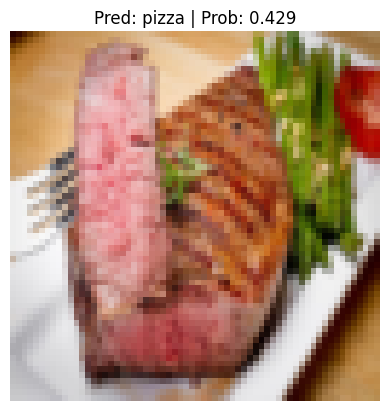

In [157]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=transform_custom_image,
                    device=device)

# Still Not Perfect But yeah